<a href="https://colab.research.google.com/github/nekotanku/colab/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [5]:
#前処理
transform=transforms.Compose([
                              transforms.ToTensor()
])
train_dataset  = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
num_batches = 100
train_dataloader = DataLoader(train_dataset, batch_size=num_batches, shuffle=True)
train_iter = iter(train_dataloader)
imgs, labels = train_iter.next()
imgs.size()

torch.Size([100, 1, 28, 28])

In [8]:
labels

tensor([3, 9, 5, 1, 4, 0, 0, 7, 5, 9, 9, 7, 5, 7, 9, 3, 9, 3, 1, 5, 0, 4, 7, 8,
        4, 3, 4, 0, 1, 0, 1, 3, 9, 9, 4, 2, 6, 7, 9, 9, 1, 7, 0, 1, 1, 2, 5, 2,
        1, 5, 4, 3, 8, 0, 7, 9, 0, 3, 3, 3, 6, 9, 0, 0, 7, 0, 2, 3, 4, 1, 0, 4,
        0, 7, 9, 2, 3, 8, 3, 9, 9, 1, 5, 9, 9, 7, 7, 3, 7, 5, 5, 3, 9, 4, 2, 2,
        6, 1, 6, 5])

In [9]:
img = imgs[0]

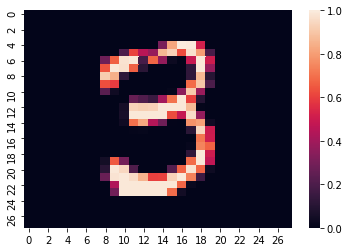

In [10]:
img_permute = img.permute(1, 2, 0)
sns.heatmap(img_permute.numpy()[:,:,0])

In [11]:
labels[0]

tensor(3)

In [14]:
#モデル構築
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28 * 28, 400),
            nn.ReLU(inplace=True),
            nn.Linear(400, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
        )
    
    def forward(self, x):
        output = self.classifier(x)
        return output

In [15]:
model = MLP()
model.to(device)

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [17]:
#訓練
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [19]:
num_epochs = 15
losses = []
accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.view(num_batches, -1)
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        loss.backward()
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    print("epoch:{}, loss:{}".format(epoch, running_loss, running_acc))

epoch:0, loss:0.1085539380973205
epoch:1, loss:0.07187357393481458
epoch:2, loss:0.05209577172955809
epoch:3, loss:0.03725220657400011
epoch:4, loss:0.028727768239720414
epoch:5, loss:0.0280052686688335
epoch:6, loss:0.02066068347664744
epoch:7, loss:0.01830756834584463
epoch:8, loss:0.018965328480068516
epoch:9, loss:0.015077194912155392
epoch:10, loss:0.013597123986007015
epoch:11, loss:0.011883122774418857
epoch:12, loss:0.015662110915515465
epoch:13, loss:0.011341743612041075
epoch:14, loss:0.008064323281744995


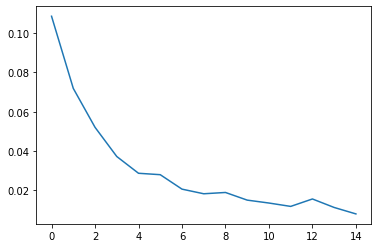

In [20]:
plt.plot(losses)

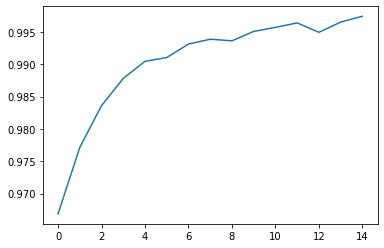

In [23]:
plt.plot(accs)

In [24]:
train_iter = iter(train_dataloader)
imgs, labels = train_iter.next()

In [25]:
labels

tensor([0, 9, 8, 8, 6, 1, 7, 9, 9, 1, 3, 8, 1, 7, 1, 7, 3, 2, 7, 8, 5, 3, 8, 3,
        2, 8, 1, 2, 9, 1, 4, 6, 6, 1, 8, 6, 5, 2, 1, 8, 4, 5, 5, 2, 1, 8, 7, 1,
        1, 8, 9, 6, 7, 4, 3, 1, 5, 7, 3, 7, 6, 4, 0, 7, 1, 7, 9, 7, 1, 0, 3, 0,
        2, 7, 3, 4, 1, 5, 7, 5, 1, 4, 1, 5, 0, 7, 5, 1, 5, 7, 3, 6, 1, 6, 2, 5,
        5, 4, 9, 8])

In [26]:
imgs_gpu = imgs.view(100, -1).to(device)
output = model(imgs_gpu)

In [27]:
pred = torch.argmax(output, dim=1)
pred

tensor([0, 9, 8, 8, 6, 1, 7, 9, 9, 1, 3, 8, 1, 7, 1, 7, 3, 2, 7, 8, 5, 3, 8, 3,
        2, 8, 1, 2, 9, 1, 4, 6, 6, 1, 8, 6, 5, 2, 1, 8, 4, 5, 5, 2, 1, 8, 7, 1,
        1, 8, 9, 6, 7, 4, 3, 1, 5, 7, 3, 7, 6, 4, 0, 7, 1, 7, 9, 7, 1, 0, 3, 0,
        2, 7, 3, 4, 1, 5, 7, 5, 1, 4, 1, 5, 0, 7, 5, 1, 5, 7, 3, 6, 1, 6, 2, 5,
        5, 4, 9, 8], device='cuda:0')

## モデルの保存・読み込み

In [29]:
#パラメータの抜き出し
params = model.state_dict()
#モデルの保存
torch.save(params, "model.prm")

In [30]:
!ls

data  model.prm  sample_data


In [32]:
#パラメータのロード
param_load = torch.load("model.prm")
#モデルのロード
model.load_state_dict(param_load)

<All keys matched successfully>